In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load dataset
data = pd.read_csv("ev_charging_patterns.csv")

# Display first few rows to understand the data structure
data.head()

,User ID,Vehicle Model,Battery Capacity (kWh),Charging Station ID,Charging Station Location,Charging Start Time,Charging End Time,Energy Consumed (kWh),Charging Duration (hours),Charging Rate (kW),Charging Cost (USD),Time of Day,Day of Week,State of Charge (Start %),State of Charge (End %),Distance Driven (since last charge) (km),Temperature (°C),Vehicle Age (years),Charger Type,User Type
0,User_1,BMW i3,108.463007,Station_391,Houston,2024-01-01 00:00:00,2024-01-01 00:39:00,60.712346,0.591363,36.389181,13.087717,Evening,Tuesday,29.371576,86.119962,293.602111,27.947953,2.0,DC Fast Charger,Commuter
1,User_2,Hyundai Kona,100.000000,Station_428,San Francisco,2024-01-01 01:00:00,2024-01-01 03:01:00,12.339275,3.133652,30.677735,21.128448,Morning,Monday,10.115778,84.664344,112.112804,14.311026,3.0,Level 1,Casual Driver
2,User_3,Chevy Bolt,75.000000,Station_181,San Francisco,2024-01-01 02:00:00,2024-01-01 04:48:00,19.128876,2.452653,27.513593,35.667270,Morning,Thursday,6.854604,69.917615,71.799253,21.002002,2.0,Level 2,Commuter
3,User_4,Hyundai Kona,50.000000,Station_327,Houston,2024-01-01 03:00:00,2024-01-01 06:42:00,79.457824,1.266431,32.882870,13.036239,Evening,Saturday,83.120003,99.624328,199.577785,38.316313,1.0,Level 1,Long-Distance Traveler
4,User_5,Hyundai Kona,50.000000,Station_108,Los Angeles,2024-01-01 04:00:00,2024-01-01 05:46:00,19.629104,2.019765,10.215712,10.161471,Morning,Saturday,54.258950,63.743786,203.661847,-7.834199,1.0,Level 1,Long-Distance Traveler


In [3]:
# 1. Data Preprocessing and Time Feature Extraction

# 1.1 Handle Missing Values
missing_values = data.isnull().sum()

# Handle Missing Values in critical columns.
data.dropna(subset=['Charging Start Time', 'Charging End Time', 'Energy Consumed (kWh)', 'Charging Cost (USD)'], inplace=True)

# 1.2 Extracting detailed time features from Charging Start Time
# Convert Charging Start Time to datetime format
data['Charging Start Time'] = pd.to_datetime(data['Charging Start Time'])
data['Charging End Time'] = pd.to_datetime(data['Charging End Time'])

# Extract hour, 15-minute interval, weekday/weekend, and month from Charging Start Time
data['Hour'] = data['Charging Start Time'].dt.hour
data['Weekday'] = data['Charging Start Time'].dt.weekday
data['Is Weekend'] = data['Weekday'] >= 5
data['Month'] = data['Charging Start Time'].dt.month

# 1.3 Categorize Time of Day into more specific periods
def categorize_time_of_day(hour):
    if 7 <= hour < 9:
        return "Morning Peak"
    elif 9 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 14:
        return "Midday"
    elif 14 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 19:
        return "Evening Peak"
    elif 19 <= hour < 23:
        return "Evening"
    else:
        return "Late Night"

data['Time of Day'] = data['Hour'].apply(categorize_time_of_day)

# Categorize Time of Day as an ordered categorical variable
time_order = ["Morning Peak", "Morning", "Midday", "Afternoon", "Evening Peak", "Evening", "Late Night"]
data['Time of Day'] = pd.Categorical(data['Time of Day'], categories=time_order, ordered=True)

# Categorize Day of Week as an ordered categorical variable
data['Day of Week'] = pd.Categorical(data['Day of Week'], categories=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], ordered=True)

# Calculate unit cost (USD per kWh) for each charging session
data['Unit Cost (USD per kWh)'] = data['Charging Cost (USD)'] / data['Energy Consumed (kWh)']

# Remove outliers in Unit Cost (USD per kWh)
Q1 = data['Unit Cost (USD per kWh)'].quantile(0.25)
Q3 = data['Unit Cost (USD per kWh)'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data = data[(data['Unit Cost (USD per kWh)'] >= lower_bound) & (data['Unit Cost (USD per kWh)'] <= upper_bound)]

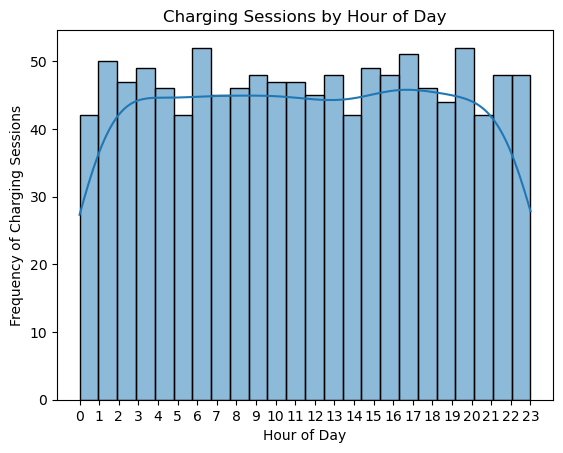

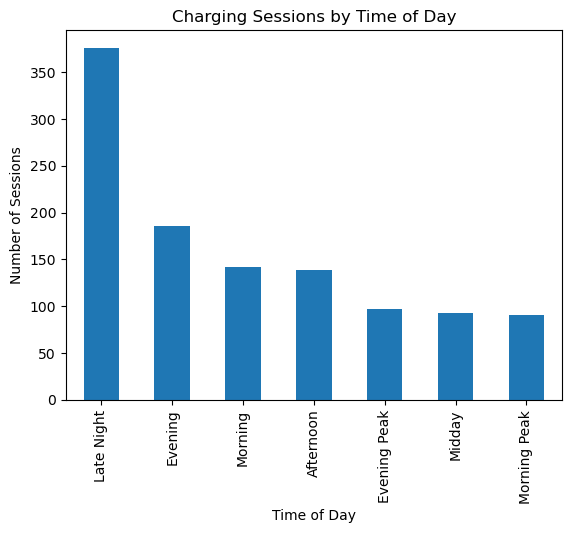

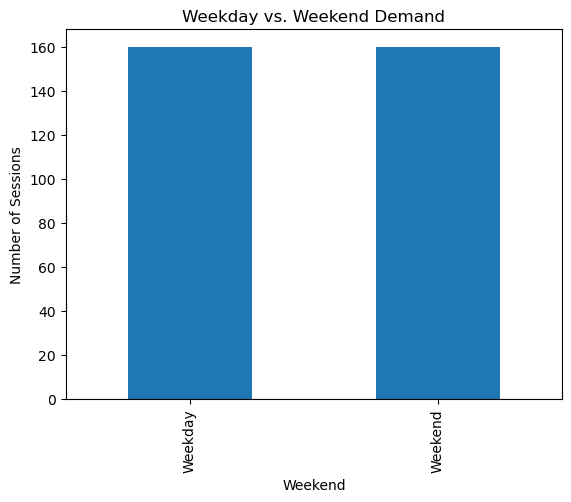

In [8]:
# 2. Demand Pattern Analysis
# 2.1 Charging Sessions Count by Time Dimension
# Count charging sessions by hour
hourly_sessions = data.groupby('Hour').size()
# plt.figure(figsize=(10, 6))
sns.histplot(data['Hour'], bins=24, kde=True)
plt.title("Charging Sessions by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Frequency of Charging Sessions")
plt.xticks(range(0, 24))
plt.show()

# Count charging sessions by Time of Day
time_of_day_sessions = data['Time of Day'].value_counts()
time_of_day_sessions.plot(kind='bar', title='Charging Sessions by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Sessions')
plt.show()

# Compare demand between weekdays and weekends
weekday_sessions = data.groupby('Is Weekend').size()
# Divide by 5 and 2 to get average number of sessions per weekday and weekend
weekday_sessions[0] = int(weekday_sessions[0] / 5)
weekday_sessions[1] = int(weekday_sessions[1] / 2)
weekday_sessions.plot(kind='bar', title='Weekday vs. Weekend Demand')
plt.xlabel('Weekend')
plt.ylabel('Number of Sessions')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()


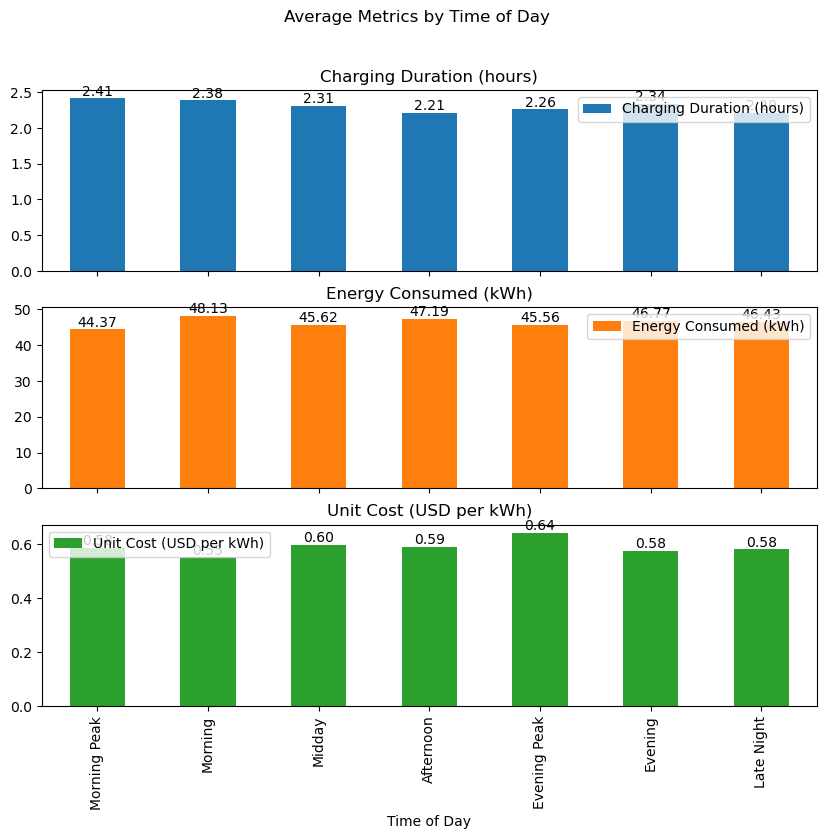

In [15]:
# 2.2 Calculating Key Metrics
# Calculate average charging duration, energy consumption, and cost for each Time of Day category
time_metrics = data.groupby('Time of Day').agg({
    'Charging Duration (hours)': 'mean',
    'Energy Consumed (kWh)': 'mean',
    'Unit Cost (USD per kWh)': 'mean'  # Updated to use unit cost
})

axes = time_metrics.plot(kind='bar', subplots=True, layout=(3, 1), figsize=(10, 8), title='Average Metrics by Time of Day')

for ax in axes.flatten():
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2., height, f'{height:.2f}', ha='center', va='bottom')

plt.show()

Busiest hour of the day: 6
Busiest day of the week: 5


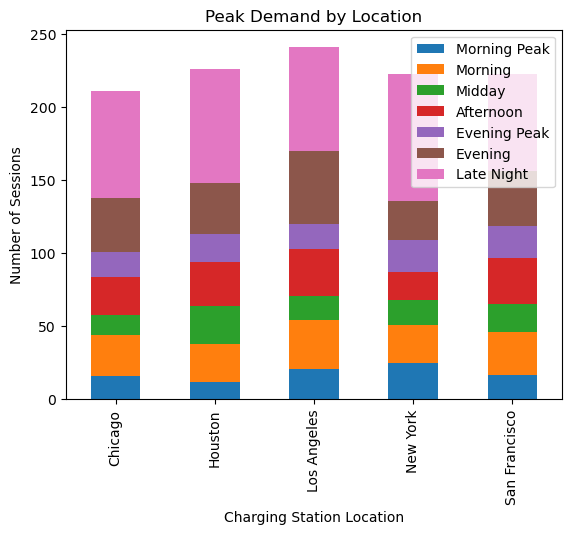

In [16]:
# 3. Peak Period Analysis

# 3.1 Identifying Peak Demand Periods
# Find the busiest hour of the day
busiest_hour = hourly_sessions.idxmax()
busiest_day = data['Weekday'].value_counts().idxmax()
print(f"Busiest hour of the day: {busiest_hour}")
print(f"Busiest day of the week: {busiest_day}")

# Analyzing peak demand differences by charging station location
peak_by_location = data.groupby(['Charging Station Location', 'Time of Day']).size().unstack()
peak_by_location.plot(kind='bar', stacked=True, title='Peak Demand by Location')
plt.xlabel('Charging Station Location')
plt.ylabel('Number of Sessions')
plt.legend(loc='upper right')
plt.show()



In [17]:
# 3.2 Analyzing Peak Period Characteristics
# Calculate average metrics during peak and non-peak times
peak_hours = data[data['Hour'].isin([7, 8, 17, 18])]
non_peak_hours = data[~data['Hour'].isin([7, 8, 17, 18])]

# Calculate average metrics during peak and non-peak times, using unit cost
peak_vs_non_peak = pd.DataFrame({
    'Avg Charging Duration (Peak)': [peak_hours['Charging Duration (hours)'].mean()],
    'Avg Charging Duration (Non-Peak)': [non_peak_hours['Charging Duration (hours)'].mean()],
    'Avg Unit Cost (Peak)': [peak_hours['Unit Cost (USD per kWh)'].mean()],
    'Avg Unit Cost (Non-Peak)': [non_peak_hours['Unit Cost (USD per kWh)'].mean()]
})

# Display the updated peak vs non-peak comparison
print(peak_vs_non_peak)

   Avg Charging Duration (Peak)  Avg Charging Duration (Non-Peak)  \
0                      2.332924                           2.26916   

   Avg Unit Cost (Peak)  Avg Unit Cost (Non-Peak)  
0              0.612744                  0.577175  


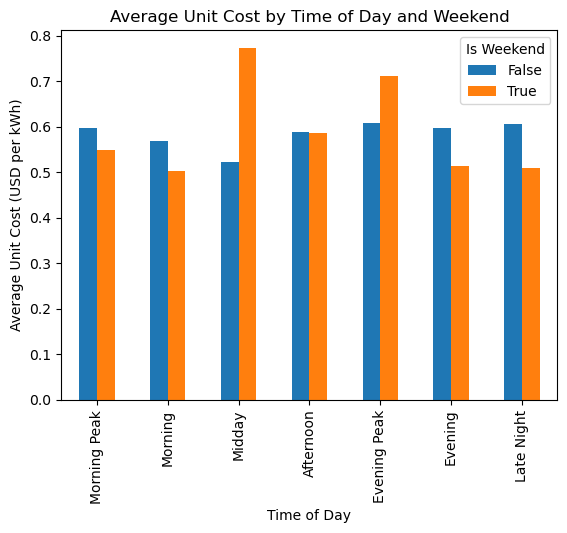

In [18]:
# 4. Cost Impact Analysis

# 4.1 Analyzing Cost by Time
# Compare average charging cost by Time of Day and between weekdays and weekends
time_costs = data.groupby(['Time of Day', 'Is Weekend'])['Unit Cost (USD per kWh)'].mean().unstack()
time_costs.plot(kind='bar', title='Average Unit Cost by Time of Day and Weekend')
plt.xlabel('Time of Day')
plt.ylabel('Average Unit Cost (USD per kWh)')
plt.show()


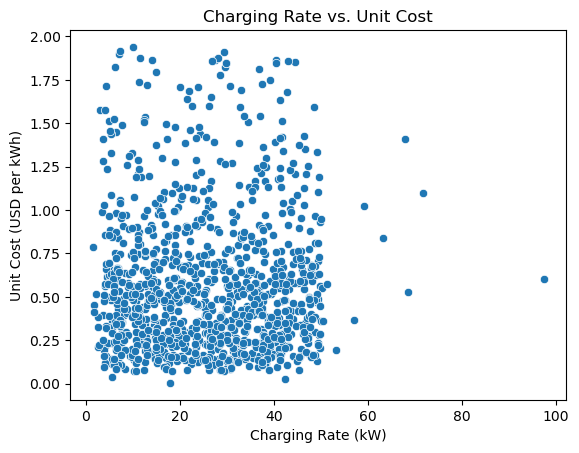

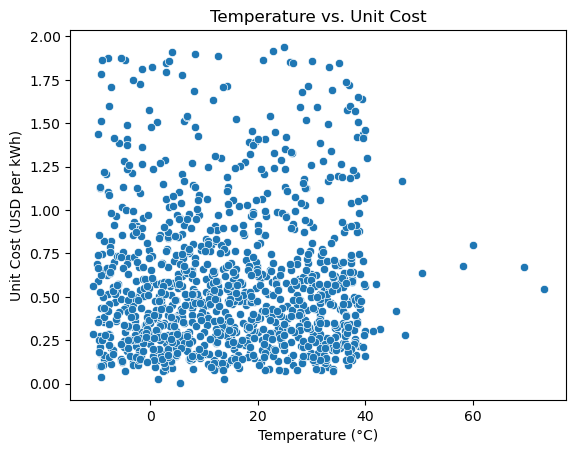

In [19]:
# 4.2 Factors Affecting Charging Costs
# Charging Rate impact on unit cost
sns.scatterplot(data=data, x='Charging Rate (kW)', y='Unit Cost (USD per kWh)')
plt.title('Charging Rate vs. Unit Cost')
plt.xlabel('Charging Rate (kW)')
plt.ylabel('Unit Cost (USD per kWh)')
plt.show()

# Temperature impact on unit cost
sns.scatterplot(data=data, x='Temperature (°C)', y='Unit Cost (USD per kWh)')
plt.title('Temperature vs. Unit Cost')
plt.xlabel('Temperature (°C)')
plt.ylabel('Unit Cost (USD per kWh)')
plt.show()


In [20]:
# 5. Optimization Recommendations
# Determine the most cost-effective charging time periods based on unit cost
cost_effective_period = time_costs.idxmin()
print("Most cost-effective charging periods (based on unit cost):")
print(cost_effective_period)

# Suggestions for avoiding peak times for reduced unit costs
print("Recommendation: Avoid peak hours (7-9 AM and 5-7 PM) for lower unit costs.")


Most cost-effective charging periods (based on unit cost):
Is Weekend
False     Midday
True     Morning
dtype: object
Recommendation: Avoid peak hours (7-9 AM and 5-7 PM) for lower unit costs.


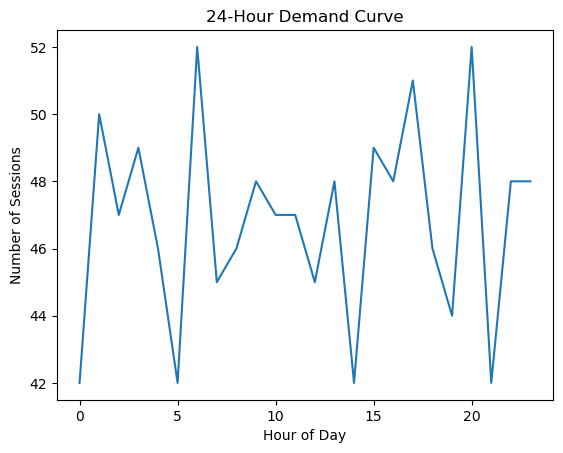

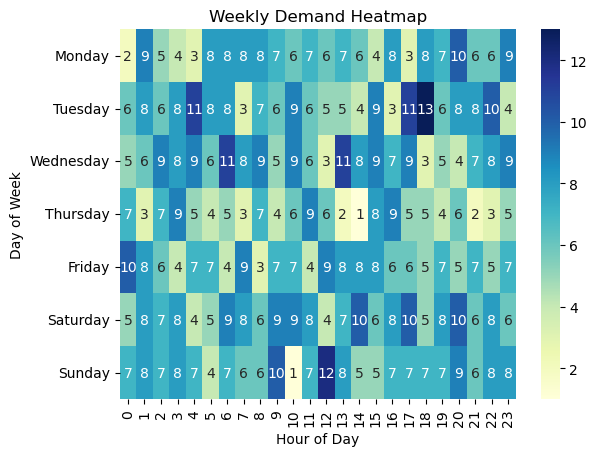

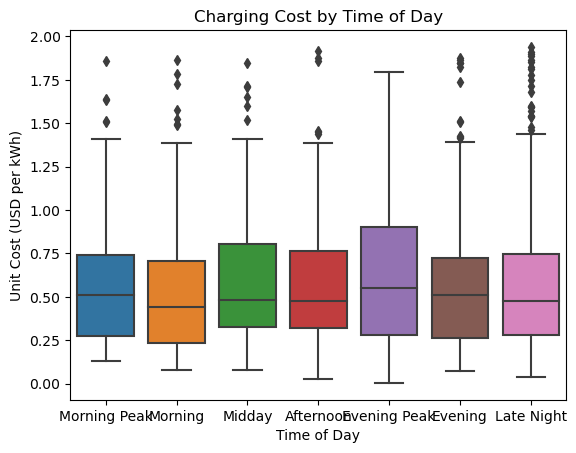

In [21]:
# 6. Visualization of Demand and Cost Trends

# 24-hour demand curve
hourly_sessions.plot(kind='line', title='24-Hour Demand Curve')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Sessions')
plt.show()

# Weekly demand heatmap
weekly_demand = data.pivot_table(index='Day of Week', columns='Hour', values='User ID', aggfunc='count').fillna(0)
sns.heatmap(weekly_demand, cmap='YlGnBu', annot=True)
plt.title('Weekly Demand Heatmap')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()

# Cost boxplot by Time of Day
sns.boxplot(data=data, x='Time of Day', y='Unit Cost (USD per kWh)')
plt.title('Charging Cost by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Unit Cost (USD per kWh)')
plt.show()
